# Compare models

In [1]:
import pickle 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from epiweeks import Week
import properscoring as ps
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
from train_models import LOOK_BACK, PREDICT_N 
from sklearn.metrics import mean_squared_error as mse

In [2]:
PATH_LSTM = '../predictions/lstm'
PATH_PGBM = '../predictions/pgbm'

## Loading list of cities

In [3]:
df = pd.read_csv('s_cities.csv', index_col = 'Unnamed: 0')
#df = df.loc[df.geocode.isin([2112209, 2111300, 3168606, 3127701, 3103504, 3143302, 3131307,
 #      2408003, 2211001, 2207702, 1502400, 1721000, 2928703, 2914802,
  #     2931350, 2925303, 2913606, 2905701])]
df = df.loc[~df.geocode.isin([3135050, 3143302, 1716109])]

df.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,ep_ini,ep_end,ep_dur,uf,state,n_last_ep,year_first_ep,year_last_ep_before_2023,start_train_chik,end_train_chik
30,3304102,Porciúncula,2023,7.408430,0.742929,0.301735,2.462195,510.383085,0.593858,0.746891,202302,202316,14,33,RJ,3,2016,2020,2015-10-01,2020-11-01
8,2303501,Cascavel,2023,21.031323,0.448789,0.300973,1.491123,196.764406,0.329365,1.124633,202302,202339,37,23,CE,3,2017,2022,2016-10-01,2022-11-01
86,2311405,Quixeramobim,2023,18.375030,0.534700,0.304761,1.754491,466.379506,0.430034,0.930290,202302,202332,30,23,CE,3,2016,2022,2015-10-01,2022-11-01
88,2306801,Jaguaribara,2023,16.405845,0.742924,0.308515,2.408069,302.646554,0.584730,1.125556,202309,202325,16,23,CE,1,2017,2017,2016-10-01,2017-11-01
122,2305407,Icó,2023,13.682780,0.429925,0.300100,1.432607,87.124092,0.301972,1.434495,202302,202334,32,23,CE,2,2017,2022,2016-10-01,2022-11-01


In [4]:
df.geocode.values

array([3304102, 2303501, 2311405, 2306801, 2305407, 2313203, 2112209,
       2111300, 3119401, 3168606, 3127701, 3168705, 3103504, 3158953,
       3126703, 3141405, 3131307, 2408003, 2205706, 2211001, 2207702,
       2806701, 2802106, 1502400, 5002308, 5002951, 1721000, 2928703,
       2914802, 2931350, 2925303, 2900801, 2905008, 2913606, 2917706,
       2905701])

## Functions
### Skill score

In [5]:
def skill_score_mse(forecast, reference, target):
    '''
    Compute the skill score using the RMSE 
    '''
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


### CRPS

In [6]:
def nearest_date_index(items, d):
    """
    Returns the index of the item in items which is nearest to the datetime d.
    """
    if isinstance(items[0], pd.Timestamp):
        items = [date.date() for date in items]
    time_diff = np.abs([date - d for date in items])
    return time_diff.argmin(0)

def compute_crps(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    between the two dates.
    '''
    cor_idx = LOOK_BACK+PREDICT_N-1
    with open(file, 'rb') as f:
        data = pickle.load(f)
    # df.iloc[df.index.get_loc(datetime.datetime(2016,2,2),method='nearest')]
    # Since the exact date may not be on the data, we need to find the nearest dates to the ones we want to evaluate
    ini_index= nearest_date_index(data['indice'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - cor_idx
    end_index = nearest_date_index(data['indice'], datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - cor_idx
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['indice'][ini_index+cor_idx]} - {data['indice'][end_index+cor_idx]}")
    # ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    # end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55

    ensemble = data['factor']*data['ensemble'][ini_index:end_index,-1, ]
    obs = data['factor']*data['target'][ini_index:end_index,-1]

    return ps.crps_ensemble(obs, ensemble).mean()

### CRPS for PGBM models

In [7]:

def compute_crps_pgbm(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    '''
    
    with open(file, 'rb') as f:
        data = pickle.load(f)

    ini_index= nearest_date_index(data['dates'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    end_index = nearest_date_index(data['dates'], datetime.strptime(end_evaluate, '%Y-%m-%d').date())
    print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['dates'][ini_index]} - {data['dates'][end_index]}")    
    # ini_index = data['dates'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date())
    # end_index = data['dates'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date())

    ensemble = data['ensemble'][ini_index:end_index]
    obs = data['target'].values[4+ini_index:4+end_index]

    return ps.crps_ensemble(obs, ensemble).mean()


def skill(baseline_score, forecast_score):
    '''
    This function is used with the compute_crps to compute the skill using the crps metric 
    '''
    return (baseline_score - forecast_score) / baseline_score


### Get predictions

In [8]:
def get_preds(path = f'../../predictions/lstm/lstm_2211001_chik_predictions_msle.pkl', label = 'dengue_model', cor_idx= LOOK_BACK+PREDICT_N-1):
    '''
    Get the prediction from the lstm models and transform it in a dataframe. 
    '''
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['indice'][cor_idx:]
    
    df[f'target_{label}'] = data['target'][:,-1]*data['factor']
    
    df[f'lower_{label}'] = data['lb'].iloc[:,-1]*data['factor']
    
    df[f'preds_{label}'] = data['pred'].iloc[:,-1]*data['factor']
    
    df[f'upper_{label}'] = data['ub'].iloc[:,-1]*data['factor']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


def get_preds_pgbm(path = f'../../predictions/pgbm/pgbm_2211001_chik_cross_predictions.pkl', label = 'dengue_model', cor_idx= LOOK_BACK+PREDICT_N-1):
    
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['dates']
    
    df[f'target_{label}'] = data['target'].values[4:]
    
    df[f'lower_{label}'] = data['preds25']
    
    df[f'preds_{label}'] = data['preds']
    
    df[f'upper_{label}'] = data['preds975']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


### Get data

In [9]:
def get_chik_data(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with all the lstm chik predictions: 
    * using the dengue model;
    * using the transf model; 
    * using the chik model. 
    '''
    
    d1 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


def get_chik_data_pgbm(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with the transf and the pgbm chik predictions: 
    * using the dengue model (pgbm);
    * using the transf model; 
    * using the chik model (pgbm). 
    '''
    
    d1 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_transf_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


### Plot Comparisons

In [10]:
def plot_comp(city, ini_evaluate = '2022-11-01', end_evaluate = '2023-10-01', model = 'DL', plot = True): 
    '''
    Function to compare the predictions in a given interval and compute the ss. 
    If the model is DL it's used the lstm model and is computed the skill score using crps 
    '''
    if model =='DL':
        df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    if model == 'PGBM': 
        df = get_chik_data_pgbm(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    
    plt.plot(df.index, df.target , color = 'black', label = 'Data', linewidth=2)

    plt.plot(df.index, df.preds_dengue_model, label = f'{model} - Dengue', color = 'tab:blue', ls = 'dashed', linewidth=2)

    plt.fill_between(df.index, df.lower_dengue_model,
                    df.upper_dengue_model,  color = 'tab:blue',
                    alpha = 0.2)


    plt.plot(df.index, df.preds_transf_model, label = f'TL', linewidth=2,
                        color = 'tab:red', ls = 'dashdot')

    plt.fill_between(df.index, df.lower_transf_model, 
                    df.upper_transf_model,
                        color = 'tab:red', alpha = 0.2)

    plt.xlabel('Date')

    plt.ylabel('New cases')

    plt.plot(df.index, df.preds_chik_model, label = f'{model} - Chik',color = 'tab:orange', ls = 'dotted', linewidth=2)

    plt.fill_between(df.index, df.lower_chik_model,
                   df.upper_chik_model, alpha = 0.2, color = 'tab:orange')


    plt.grid()

    plt.legend()

    plt.title(f'Chikungunya forecasts at {city} ({model})')
    
    
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(20)
    plt.savefig(f'../figures/forecast_{city}_{model}.png', dpi = 300, bbox_inches = 'tight') 
    if plot:
        plt.show()
    else:
        plt.close()
    scores = {}
    print('Skill score using RMSE')
    
    scores['RMSE_SS'] = {
        'TL vs DL - dengue': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_dengue_model, 
                                            target = df.target),
        'TL vs DL - chik': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_chik_model, 
                                            target = df.target) 
    }
    print('TL vs DL - dengue:', scores['RMSE_SS']['TL vs DL - dengue'])
    print('TL vs DL - chik:', scores['RMSE_SS']['TL vs DL - chik'])
    
    if model == 'DL':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
        scores['CRPS_SS'] = {
            'TL vs DL - dengue': skill(baseline_score = crps1, 
                                          forecast_score = crps2),
            'TL vs DL - chik': skill(baseline_score = crps3, 
                                          forecast_score = crps2)
        }
        print('TL vs DL - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs DL - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))
        json.dump(scores, open(f'../scores/lstm/scores_{city}_{model}.json', 'w'))
    if model == 'PGBM':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_cross_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps_pgbm(f'{PATH_PGBM}/pgbm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
        scores['CRPS_SS'] = {
            'TL vs PGBM - dengue': skill(baseline_score = crps1, 
                                          forecast_score = crps2),
            'TL vs PGBM - chik': skill(baseline_score = crps3, 
                                          forecast_score = crps2)
        }
        print('TL vs PGBM - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs PGBM - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))
        json.dump(scores, open(f'../scores/pgbm/scores_{city}_{model}.json', 'w'))

    return
    

In [11]:
ini_evaluate = '2022-11-01'
end_evaluate = '2023-11-01'

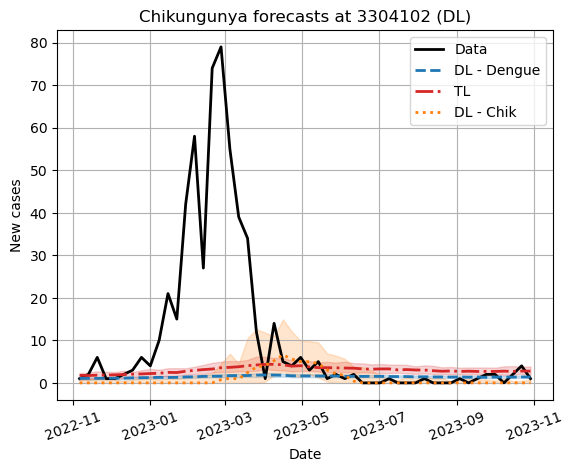

Skill score using RMSE
TL vs DL - dengue: 0.03393699371121217
TL vs DL - chik: 0.05092224370614551
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.02676173415759348
TL vs DL - chik: 0.011085325220465096


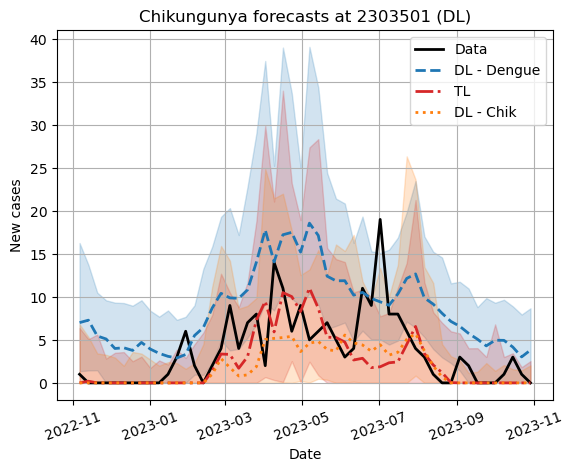

Skill score using RMSE
TL vs DL - dengue: 0.3671406750351832
TL vs DL - chik: -0.061723888035453145
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.5498288123899747
TL vs DL - chik: -0.026517154738569068


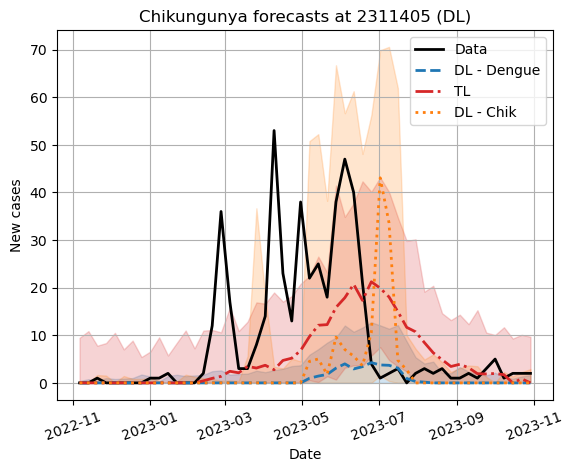

Skill score using RMSE
TL vs DL - dengue: 0.17031484688347198
TL vs DL - chik: 0.2183856109897424
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.2349046793785688
TL vs DL - chik: 0.1890970767772804


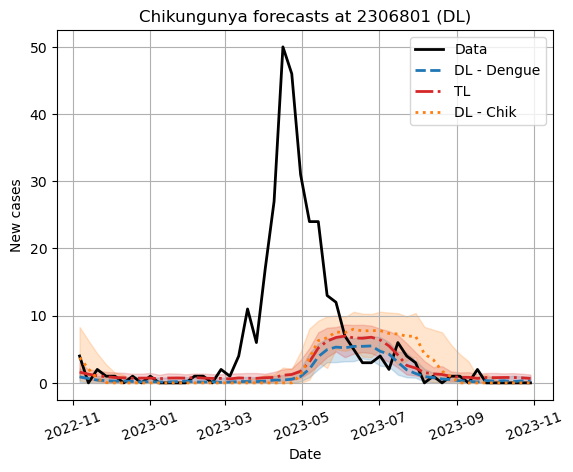

Skill score using RMSE
TL vs DL - dengue: 0.02335473045296188
TL vs DL - chik: 0.02438128673841622
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.029120249001701355
TL vs DL - chik: 0.04878591448548781


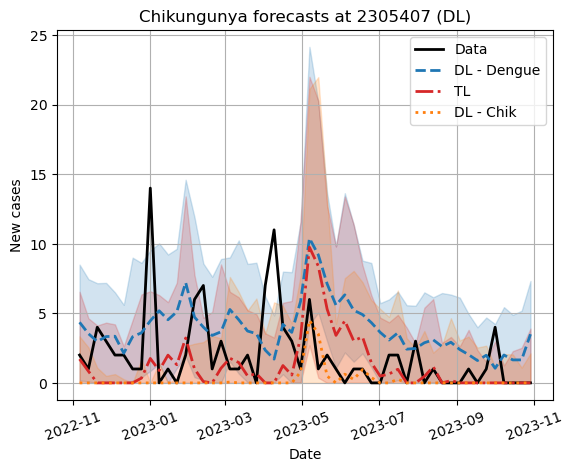

Skill score using RMSE
TL vs DL - dengue: 0.08457339476187542
TL vs DL - chik: -0.018238852483121182
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.2758487669132397
TL vs DL - chik: 0.058393428245558744


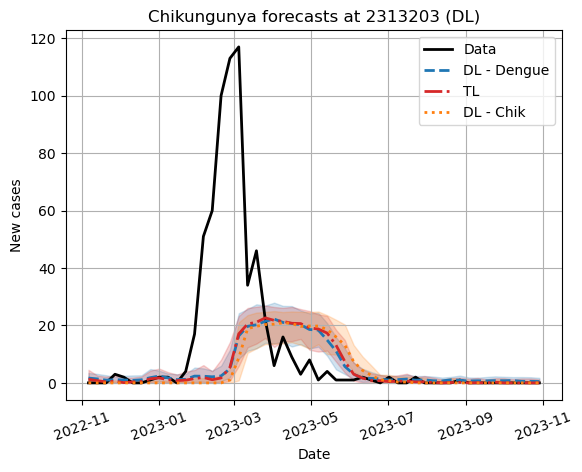

Skill score using RMSE
TL vs DL - dengue: -0.001860024054215259
TL vs DL - chik: 0.0445005322646953
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.000646507572802157
TL vs DL - chik: 0.06805184362427823


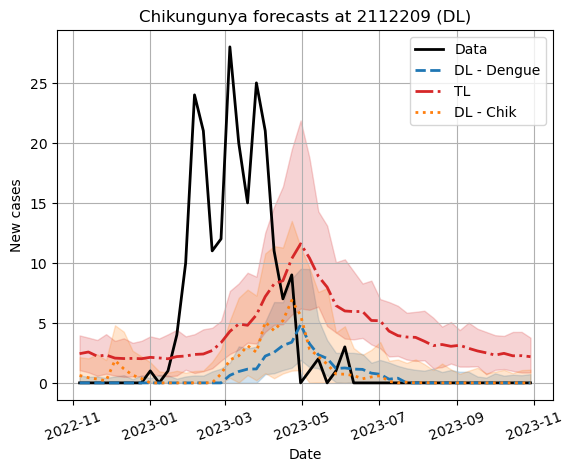

Skill score using RMSE
TL vs DL - dengue: 0.08069526250449999
TL vs DL - chik: 0.027290954738491635
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.24855673026434366
TL vs DL - chik: -0.38336142280759605


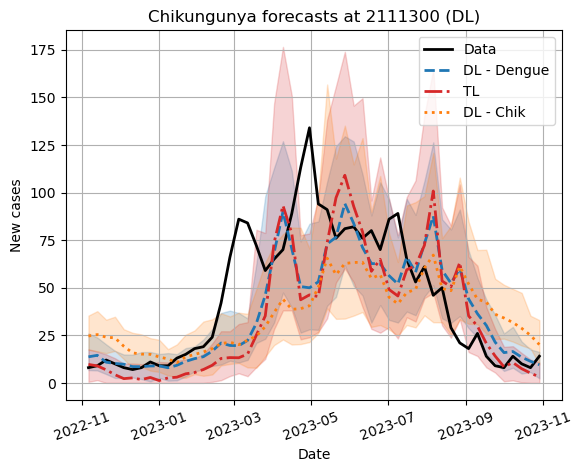

Skill score using RMSE
TL vs DL - dengue: -0.13166235283499006
TL vs DL - chik: 0.04832167689256417
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.15062285139297174
TL vs DL - chik: 0.1768758211926174


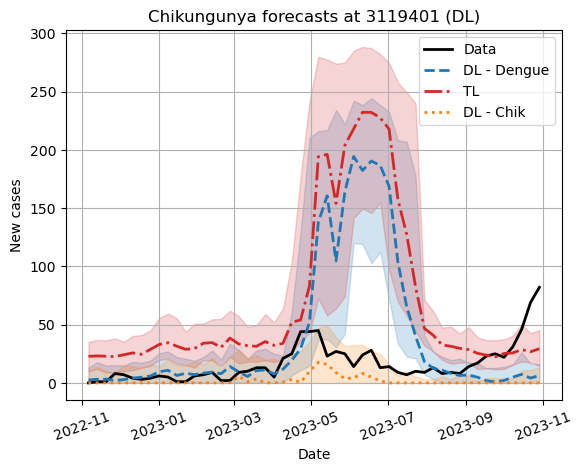

Skill score using RMSE
TL vs DL - dengue: -0.32021548035391456
TL vs DL - chik: -2.9148014797953867
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.6521516100373927
TL vs DL - chik: -3.2305817019163654


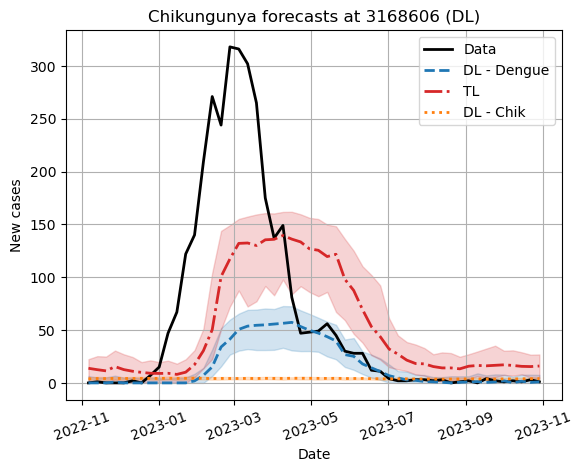

Skill score using RMSE
TL vs DL - dengue: 0.19527327370170444
TL vs DL - chik: 0.31066879057718266
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.012713787902495456
TL vs DL - chik: 0.2540962770678849


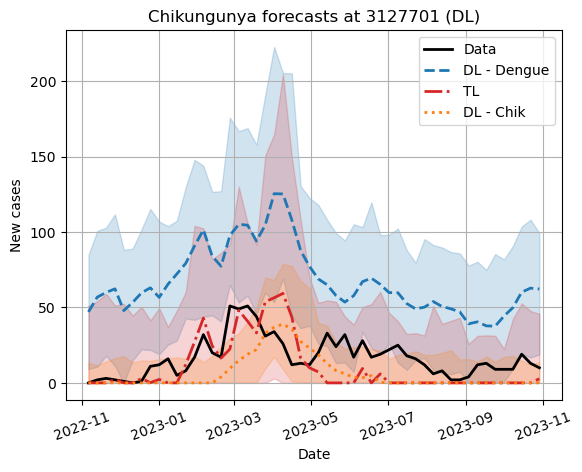

Skill score using RMSE
TL vs DL - dengue: 0.7171457330456708
TL vs DL - chik: 0.06487015658438544
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.7873066641513331
TL vs DL - chik: 0.13993115483126561


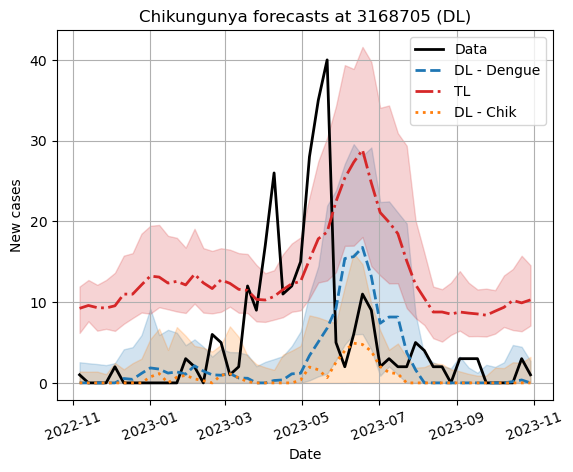

Skill score using RMSE
TL vs DL - dengue: -0.22172870748088513
TL vs DL - chik: -0.16449288573660148
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.9489341132532341
TL vs DL - chik: -0.9839721110259225


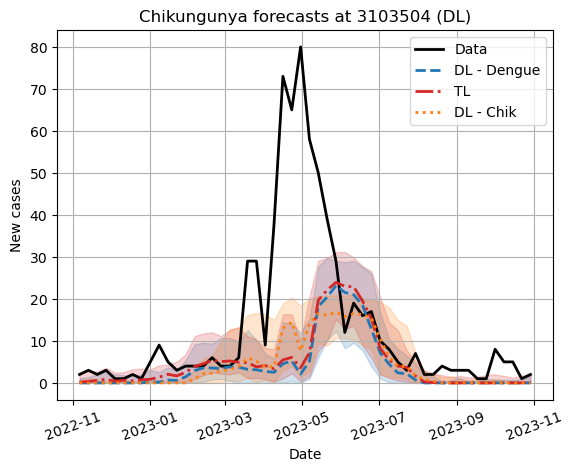

Skill score using RMSE
TL vs DL - dengue: 0.02522739019587794
TL vs DL - chik: -0.07428412301170395
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.05971521262770644
TL vs DL - chik: 0.0008417044668124678


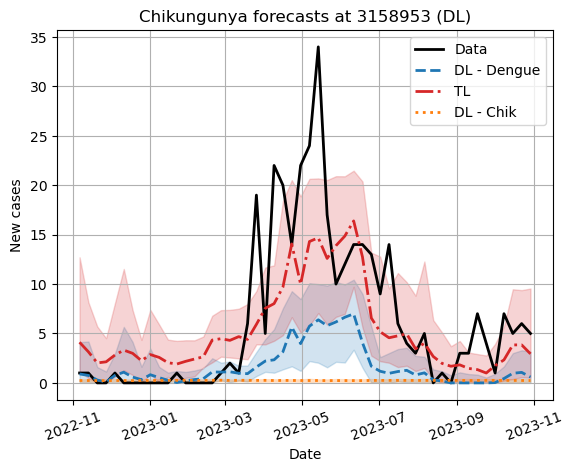

Skill score using RMSE
TL vs DL - dengue: 0.33362786351429075
TL vs DL - chik: 0.4618746005389991
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.3342734930913731
TL vs DL - chik: 0.5180634857484875


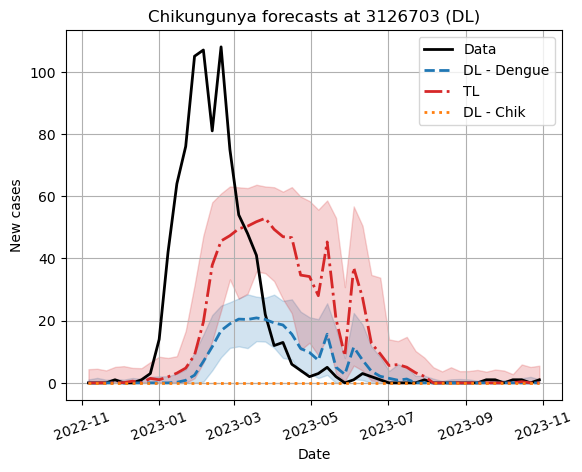

Skill score using RMSE
TL vs DL - dengue: 0.052736497266898996
TL vs DL - chik: 0.1642659058928937
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.06534876346923635
TL vs DL - chik: 0.12675541164810508


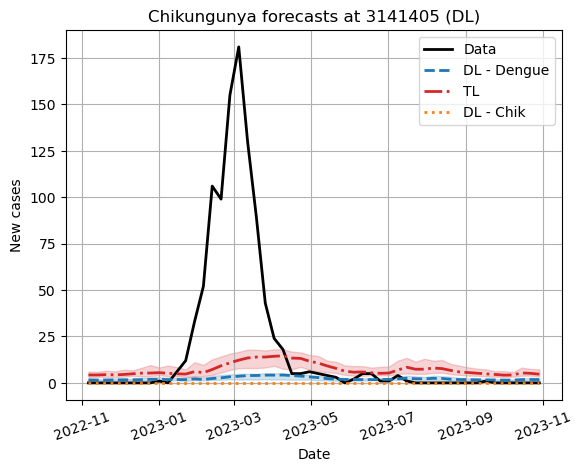

Skill score using RMSE
TL vs DL - dengue: 0.060244658261116135
TL vs DL - chik: 0.08695077511217097
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.01723719529191011
TL vs DL - chik: 0.017148597704170324


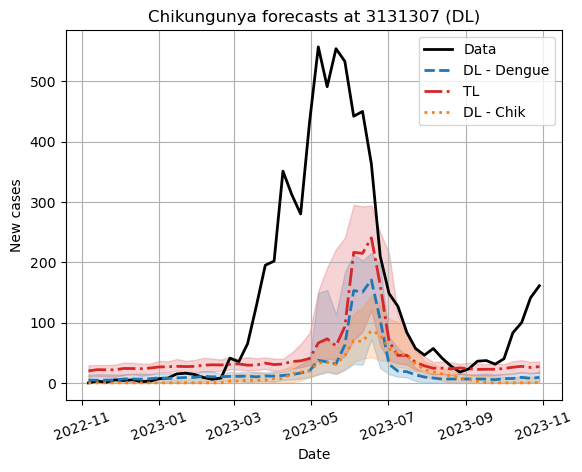

Skill score using RMSE
TL vs DL - dengue: 0.09357185600240592
TL vs DL - chik: 0.13518327399796592
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.13669764535192916
TL vs DL - chik: 0.19039203510525152


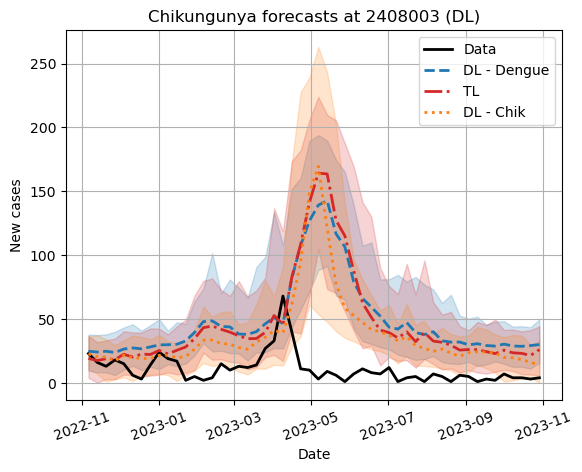

Skill score using RMSE
TL vs DL - dengue: -0.04929603215425371
TL vs DL - chik: -0.2154358748009393
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.08610144225275122
TL vs DL - chik: -0.2951831461368615


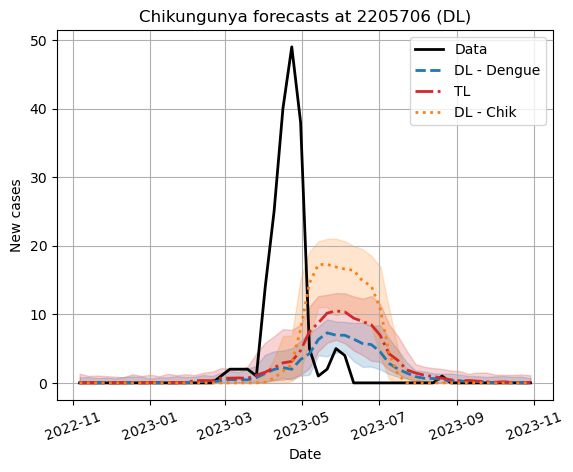

Skill score using RMSE
TL vs DL - dengue: -0.004630966765051925
TL vs DL - chik: 0.0926133393815517
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.09287219770108218
TL vs DL - chik: 0.19153949757059838


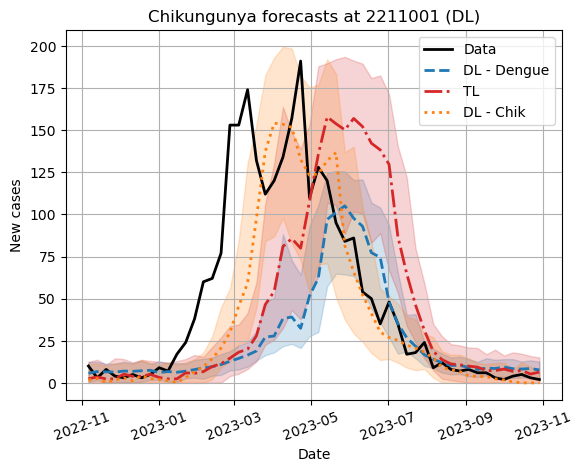

Skill score using RMSE
TL vs DL - dengue: -0.010986913856389835
TL vs DL - chik: -0.6758587674831507
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.07443472429872751
TL vs DL - chik: -1.1037242152676259


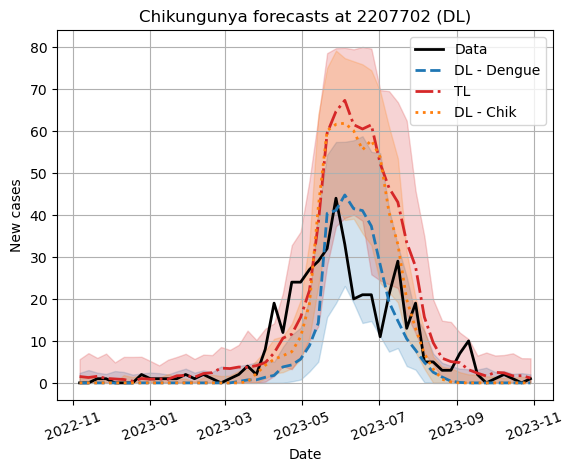

Skill score using RMSE
TL vs DL - dengue: -0.6903944779009861
TL vs DL - chik: -0.07770967598319967
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.5421976388709518
TL vs DL - chik: -0.03954442528943457


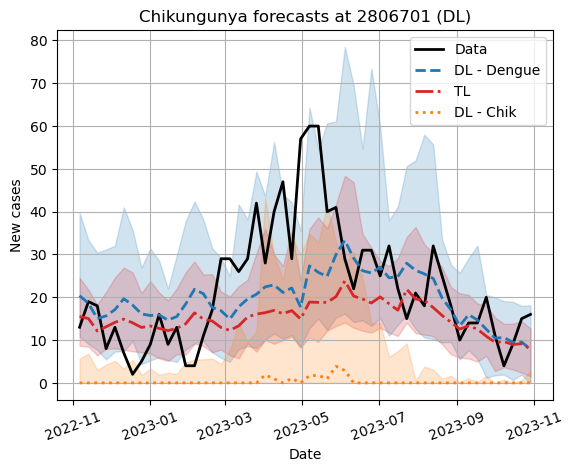

Skill score using RMSE
TL vs DL - dengue: -0.16220055104264786
TL vs DL - chik: 0.43620225085475295
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.23511692808593693
TL vs DL - chik: 0.570001416942079


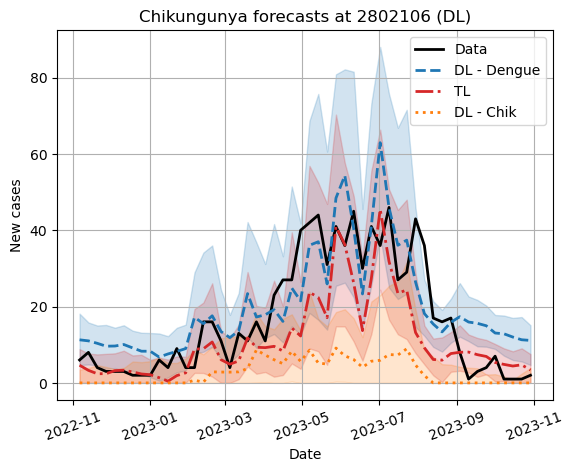

Skill score using RMSE
TL vs DL - dengue: -0.15748346932160406
TL vs DL - chik: 0.4359120716496061
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.0011384789458731023
TL vs DL - chik: 0.5416511631338317


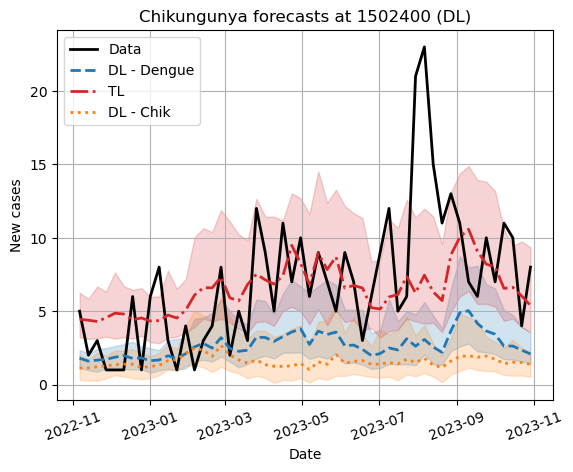

Skill score using RMSE
TL vs DL - dengue: 0.29862586693101245
TL vs DL - chik: 0.3972666299466987
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.36663874431319954
TL vs DL - chik: 0.5032769763672629


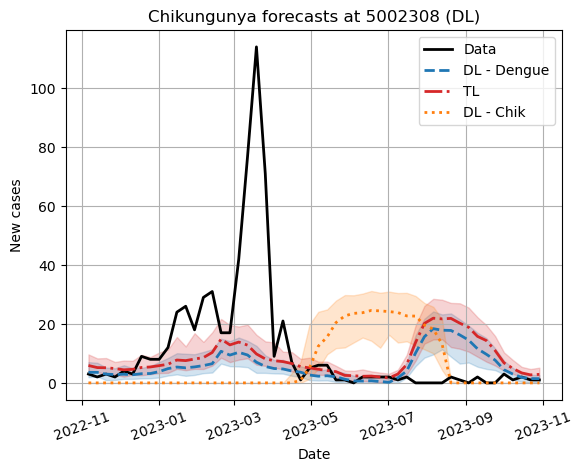

Skill score using RMSE
TL vs DL - dengue: 0.020090660046148345
TL vs DL - chik: 0.17544608347415747
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.000996126393264418
TL vs DL - chik: 0.32931004109627215


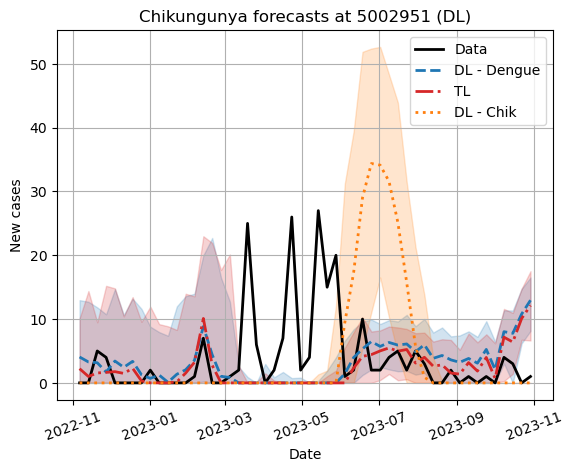

Skill score using RMSE
TL vs DL - dengue: 0.025619438427962216
TL vs DL - chik: 0.3261431578519236
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.08486677604267642
TL vs DL - chik: 0.3392767280580045


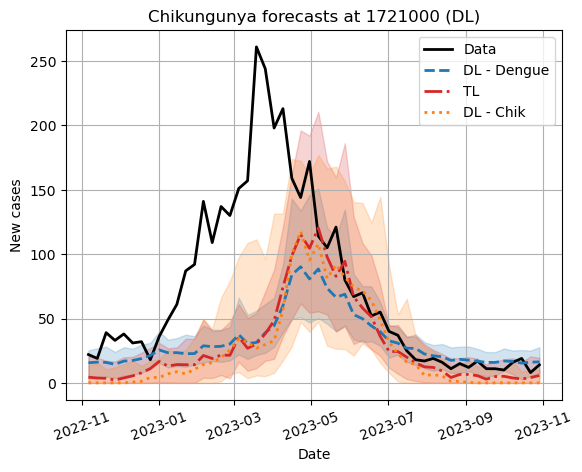

Skill score using RMSE
TL vs DL - dengue: -0.001647279109431521
TL vs DL - chik: 0.04377972357110982
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.01630722303617621
TL vs DL - chik: 0.049268777714239466


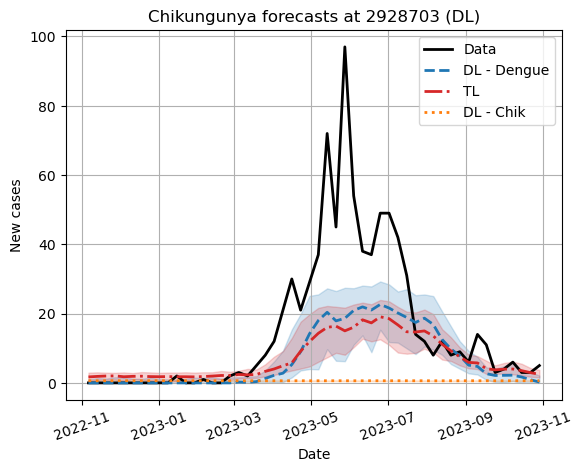

Skill score using RMSE
TL vs DL - dengue: -0.07242912572318949
TL vs DL - chik: 0.28126249845548357
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.10301538668562621
TL vs DL - chik: 0.39851775465350175


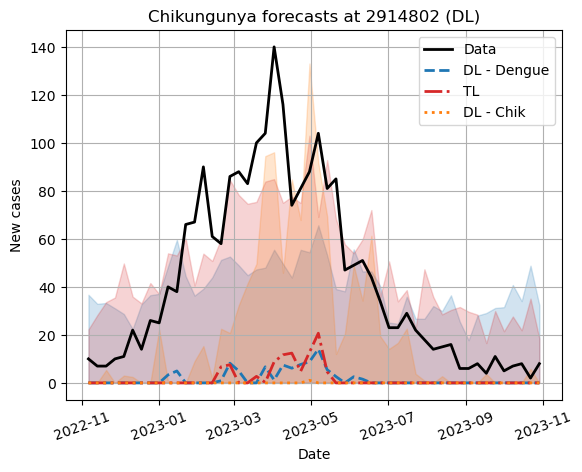

Skill score using RMSE
TL vs DL - dengue: 0.00811924113760576
TL vs DL - chik: 0.051564302525870964
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.05780921588161032
TL vs DL - chik: 0.21256642000023968


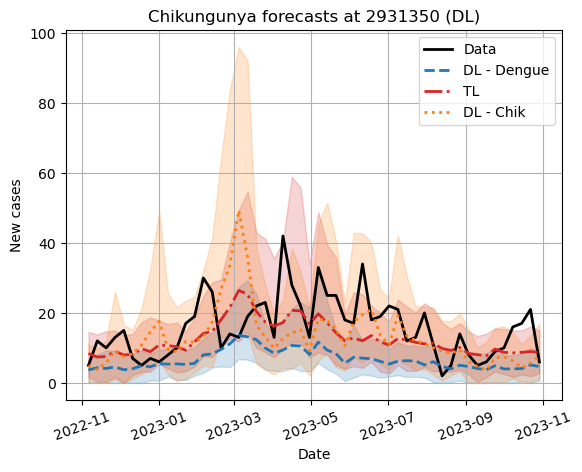

Skill score using RMSE
TL vs DL - dengue: 0.3123681852307929
TL vs DL - chik: 0.24216698103023016
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.4256647569665788
TL vs DL - chik: 0.1942506954660957


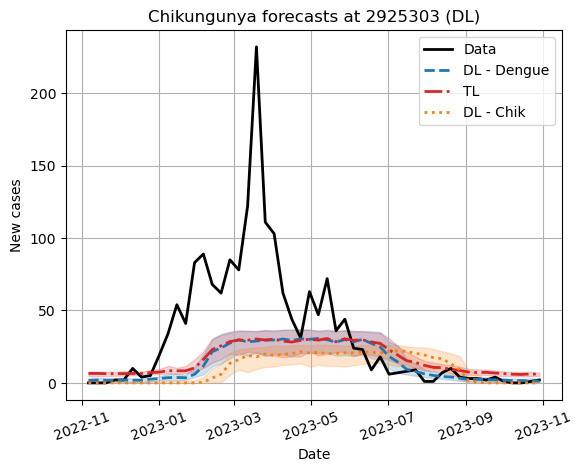

Skill score using RMSE
TL vs DL - dengue: 0.015015540171438135
TL vs DL - chik: 0.12615538396863246
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.048263906558333375
TL vs DL - chik: 0.1524794103540092


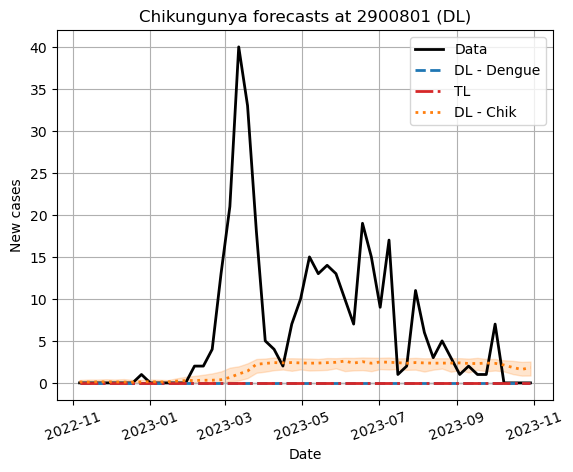

Skill score using RMSE
TL vs DL - dengue: 0.0
TL vs DL - chik: -0.10747334705746847
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 2.981501810912297e-07
TL vs DL - chik: -0.21346017823343824


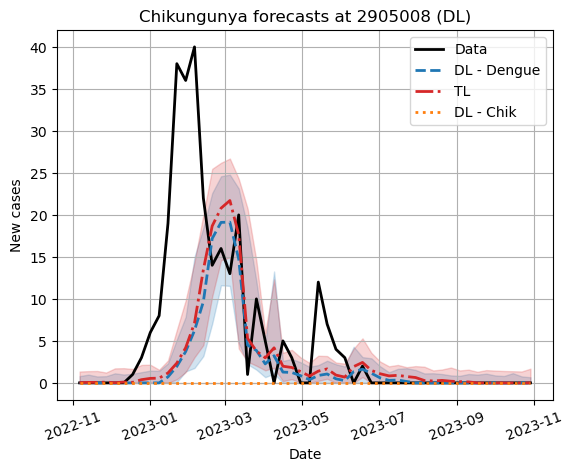

Skill score using RMSE
TL vs DL - dengue: 0.022832878802430456
TL vs DL - chik: 0.20530974800512203
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.0056748051282517155
TL vs DL - chik: 0.32975251563975655


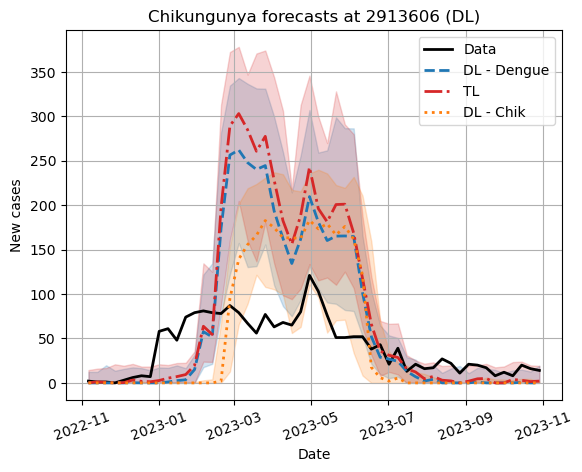

Skill score using RMSE
TL vs DL - dengue: -0.1934931262174695
TL vs DL - chik: -0.4909622581302382
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.17051649036211386
TL vs DL - chik: -0.2536486988053165


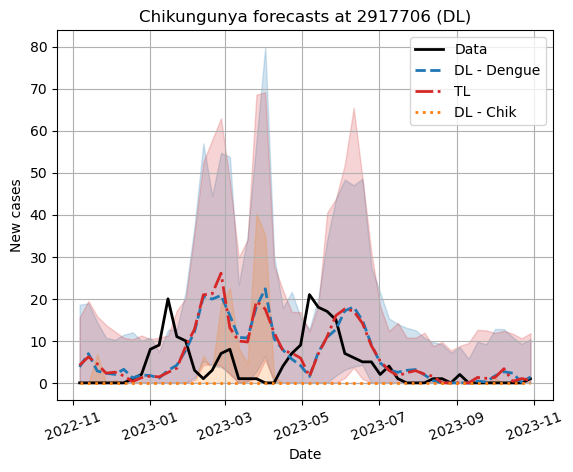

Skill score using RMSE
TL vs DL - dengue: -0.0049935861242143
TL vs DL - chik: -0.21243989680326836
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.010368208546965251
TL vs DL - chik: -0.07245621912165996


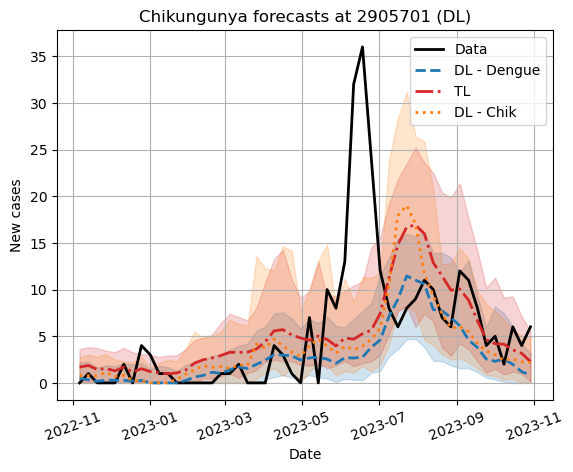

Skill score using RMSE
TL vs DL - dengue: 0.03914058356350081
TL vs DL - chik: 0.05078105317323611
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: -0.05761148643233229
TL vs DL - chik: -0.004347519549289968


In [12]:
for city in df.geocode:
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL')

In [13]:
df.head()

,geocode,muni_name,year,peak_week,beta,gamma,R0,total_cases,alpha,sum_res,ep_ini,ep_end,ep_dur,uf,state,n_last_ep,year_first_ep,year_last_ep_before_2023,start_train_chik,end_train_chik
30,3304102,Porciúncula,2023,7.408430,0.742929,0.301735,2.462195,510.383085,0.593858,0.746891,202302,202316,14,33,RJ,3,2016,2020,2015-10-01,2020-11-01
8,2303501,Cascavel,2023,21.031323,0.448789,0.300973,1.491123,196.764406,0.329365,1.124633,202302,202339,37,23,CE,3,2017,2022,2016-10-01,2022-11-01
86,2311405,Quixeramobim,2023,18.375030,0.534700,0.304761,1.754491,466.379506,0.430034,0.930290,202302,202332,30,23,CE,3,2016,2022,2015-10-01,2022-11-01
88,2306801,Jaguaribara,2023,16.405845,0.742924,0.308515,2.408069,302.646554,0.584730,1.125556,202309,202325,16,23,CE,1,2017,2017,2016-10-01,2017-11-01
122,2305407,Icó,2023,13.682780,0.429925,0.300100,1.432607,87.124092,0.301972,1.434495,202302,202334,32,23,CE,2,2017,2022,2016-10-01,2022-11-01


## New qq plot (only DL models by now):

In [14]:
def gen_data_to_qq(city, ini_evaluate,end_evaluate):
    
    df_end = pd.DataFrame()
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)


    df_end['dates'] = df.index
    df_end['dates'] = pd.to_datetime(df_end['dates'])
    df_end['week'] = [Week.fromdate(i).weektuple()[1] for i in df_end['dates']] 
    df_end['target_chik'] = df['target'].values
    df_end['preds_dl_dengue'] =  df['preds_dengue_model'].values
    
    df_end['preds_tl'] =  df['preds_chik_model'].values

    df_end['preds_dl_chik'] = df['preds_chik_model'].values
    
    # adicionando os dados de dengue: 
    
    df_dengue = pd.read_csv(f'../data/dengue_{city}_cluster.csv.gz', index_col = 'Unnamed: 0' , usecols = ['Unnamed: 0', f'casos_{city}'])
    
    
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue['week'] = [Week.fromdate(i).weektuple()[1] for i in df_dengue.index] 
    
    df_dengue['year'] = [Week.fromdate(i).weektuple()[0] for i in df_dengue.index]
    
    #adicionando data faltando 
    
    v = ( df_dengue.loc['2018-04-01'][f'casos_{city}'] + df_dengue.loc['2018-04-15'][f'casos_{city}'] )/2
    
    f = {f'casos_{city}':v, 'week':15 , 'year':2018}
    
    
    s = pd.DataFrame(f, index=['2018-04-08'])
    
    # df_dengue = df_dengue.append(s)
    df_dengue = pd.concat([df_dengue, s], axis=0)
 
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue = df_dengue.sort_index()
    
    
    for y in np.arange(2010, max(df_end.dates.dt.year)):
        
        df_s = df_dengue.loc[df_dengue.year == y]
        
        try:

            df_end[f'dengue_{y}'] = df_s.loc[ df_s.week.isin(df_end.week)][f'casos_{city}'].values
            
        except:
                        
            print('Erro para o ano:')
            print(y)
    


    
    return df_end

In [15]:
def plot_cross_qq(ax, q_o, q_p, title):
    sns.kdeplot(x = q_o[len(q_p) - len(q_o):], y = q_p, ax =ax, fill = True)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
    
    max_v = max( max(q_p), max(q_o))
    
    ax.set_xlim([0, max_v])
    ax.set_ylim([0, max_v])
    ax.plot([0, 100], [0, 100], 'k')
    
    ax.set_title(f'{title} - p.25: {round(np.percentile(q_p - q_o, 25),2)} - p.50: {round(np.median(q_p - q_o), 2)} - p.75: {round(np.percentile(q_p - q_o, 75), 2)}')
    #P.title(f'Transfer prediction percentiles with {model_name.lower()} for {doenca} at {city_name}')

def gen_qq_plot(city, ini_evaluate, end_evaluate, plot=True):
    
    df =  gen_data_to_qq(city, ini_evaluate, end_evaluate)
    
    cols = df.columns[ df.columns.str.startswith('dengue')]
    
    obs_preds = df[cols].values

    chik = df['target_chik'].values

    pred_tl = df['preds_tl'].values

    pred_dl_dengue = df['preds_dl_dengue'].values
    
    pred_dl_chik = df['preds_dl_chik'].values

    q_o = ss.percentileofscore(obs_preds, chik)

    q_p_dl_dengue = ss.percentileofscore(obs_preds, pred_dl_dengue)
    
    q_p_dl_chik = ss.percentileofscore(obs_preds, pred_dl_chik)

    q_p_tl = ss.percentileofscore(obs_preds, pred_tl)
    
    fig, ax = plt.subplots(1,3, figsize = (12,4))

    fig.suptitle(f'City - {city}', fontsize=12)
    
    plot_cross_qq(ax[0], q_o, q_p_tl, title = 'TL')

    plot_cross_qq(ax[1], q_o, q_p_dl_dengue, title = 'DL - dengue')
    
    plot_cross_qq(ax[2], q_o, q_p_dl_dengue, title = 'DL - chik')
    plt.tight_layout()
    
    plt.savefig(f'../figures/qq_plot_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    
    if plot:
        plt.show()
    
    return


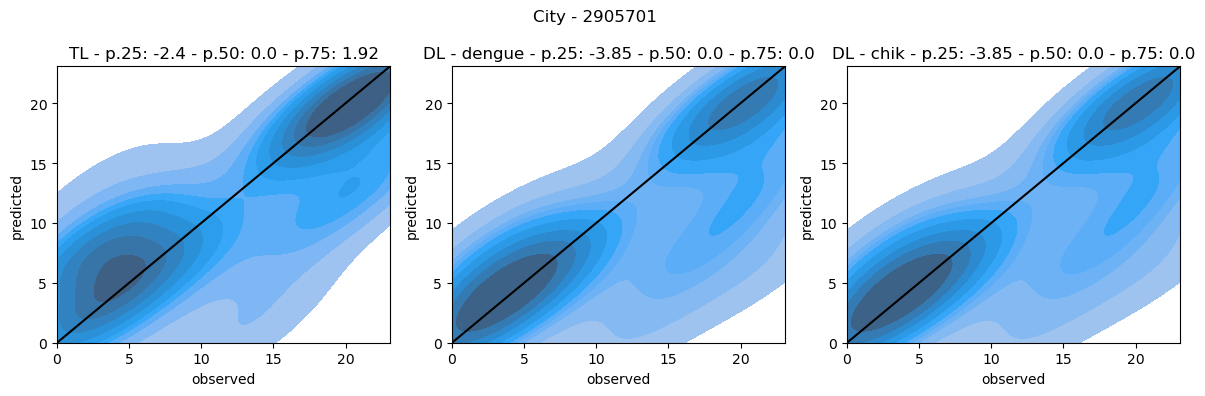

In [16]:
gen_qq_plot(city = city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate)

In [17]:
from pgbm.sklearn import HistGradientBoostingRegressor, crps_ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import numpy as np
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
model = HistGradientBoostingRegressor(random_state=0).fit(X_train, y_train)  
yhat_point, yhat_point_std = model.predict(X_test, return_std=True)
yhat_dist = model.sample(yhat_point, yhat_point_std, n_estimates=1000, random_state=0)

In [18]:
yhat_dist.shape

(1000, 2064)

In [19]:
yhat_point.shape

(2064,)

In [20]:
np.percentile(yhat_dist, 0.025, axis=0).shape

(2064,)

In [21]:
end_date = '2023-11-01'
for city in df.geocode:
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL', plot = False)
    plot_comp(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'PGBM', plot = False)
    gen_qq_plot(city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, plot=False)

Skill score using RMSE
TL vs DL - dengue: 0.03393699371121217
TL vs DL - chik: 0.05092224370614551
Skill score using CRPS
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
requested dates: 2022-11-01 - 2023-11-01, found dates: 2022-10-30 00:00:00 - 2023-10-29 00:00:00
TL vs DL - dengue: 0.02676173415759348
TL vs DL - chik: 0.011085325220465096


FileNotFoundError: [Errno 2] No such file or directory: '../predictions/pgbm/pgbm_3304102_chik_cross_pred.pkl'